### Throw / Gravity predictor

A small test project for RNNs in Keras. Simulates a thrown ball with a parabola curve and bounces from the ground and tries to predict it.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import math

/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

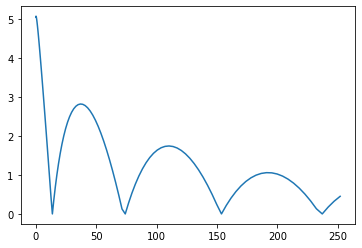

In [2]:
def generate_throw(start_height, throw_speed_x, throw_speed_y, resolution, points):
    x = 0
    y = start_height
    vx = throw_speed_x
    vy = throw_speed_y
    
    result = np.ndarray(shape=(points, 4))
    
    for step in range(points):
        x += vx * resolution
        y += vy * resolution
        vx += 0.95 ** resolution
        vy -= 9.81 * resolution
        
        if y <= 0:
            y = 0
            vy *= -0.7
        
        result[step, :] = [x, y, vx, vy]
    
    return result

throw = generate_throw(5, 1, 1, 0.05, 100)
plt.plot(throw[:, 0], throw[:, 1])

(60, 40, 2) (60, 2)


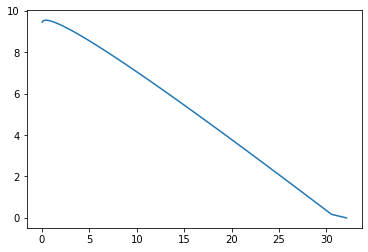

In [3]:
# Generates a specified amount of data using the "generate_throw" function.
# A throw of random length is generated and sub-sampled for the specified time length.
# This is repeated until the desired size is met.
# Return values are X and y, where X has shape (n_steps, series_length, 2) and y has shape (n_steps, 4).
# n_steps = n_throws * (throw_length - series_length)
def generate_data(n_throws, throw_length, series_length):
    n_steps = n_throws * (throw_length - series_length)
    X = np.ndarray(shape=(n_steps, series_length, 2))
    y = np.ndarray(shape=(n_steps, 2))
    
    i = 0
    for k in range(n_throws):
        
        h = np.random.rand() * 10
        vx = abs(np.random.randn())
        vy = np.random.rand() * 5
        
        throw = generate_throw(h, vx, vy, 4 / throw_length, throw_length)
        for l in range(throw_length - series_length):
            X[i, :, :] = throw[l:l+series_length, 0:2]
            y[i, :] = throw[l + series_length, 0:2]
            i += 1
    
    return X, y

X, y = generate_data(1, 100, 40)
print(X.shape, y.shape)
plt.plot(X[0, :, 0], X[0, :, 1])

In [4]:
SERIES_LENGTH = 40

X_train, y_train = generate_data(200, 100, SERIES_LENGTH)
X_test, y_test = generate_data(20, 100, SERIES_LENGTH)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12000, 40, 2) (12000, 2) (1200, 40, 2) (1200, 2)


### Create simple model

In [6]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
model.add(keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='relu'))

model.build((None, SERIES_LENGTH, 2))

model.compile(
    optimizer='adam',
    loss='mae')

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40, 64)            17152     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 58,625
Trainable params: 58,625
Non-trainable params: 0
_________________________________________________________________


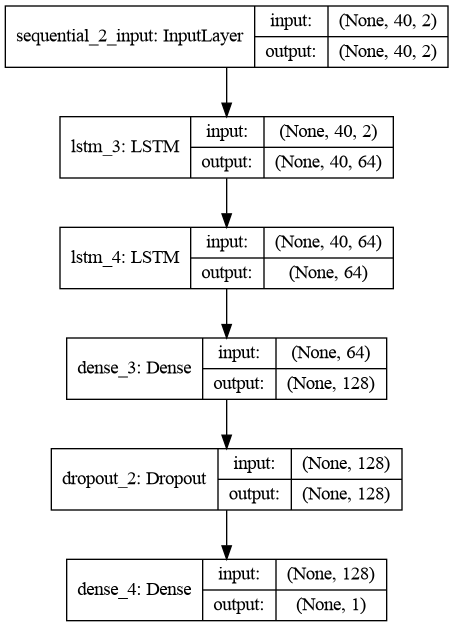

In [7]:
from IPython.display import Image
import pydot

keras.utils.plot_model(model, to_file=f'modelplot.png', show_shapes=True)

Image(f'modelplot.png')

In [8]:
y_train[:, 1:2].shape

(12000, 1)

In [15]:
model.fit(
    X_train,
    y_train[:, 1:2],
    validation_data=(X_test, y_test[:, 1:2]),
    epochs=50,
    batch_size=256
)

Train on 12000 samples, validate on 1200 samples
Epoch 1/50
12000/12000 [==============================] - 7s 616us/step - loss: 0.0974 - val_loss: 0.2358
Epoch 2/50
12000/12000 [==============================] - 7s 606us/step - loss: 0.0945 - val_loss: 0.1753
Epoch 3/50
12000/12000 [==============================] - 7s 592us/step - loss: 0.0937 - val_loss: 0.1976
Epoch 4/50
12000/12000 [==============================] - 7s 594us/step - loss: 0.0971 - val_loss: 0.1415
Epoch 5/50
12000/12000 [==============================] - 8s 644us/step - loss: 0.0992 - val_loss: 0.2387
Epoch 6/50
12000/12000 [==============================] - 8s 634us/step - loss: 0.0973 - val_loss: 0.2100
Epoch 7/50
12000/12000 [==============================] - 8s 644us/step - loss: 0.0913 - val_loss: 0.2296
Epoch 8/50
12000/12000 [==============================] - 8s 646us/step - loss: 0.0933 - val_loss: 0.1331
Epoch 9/50
12000/12000 [==============================] - 8s 675us/step - loss: 0.0957 - val_loss: 0.17

### Testing

In [22]:
i = np.random.randint(0, len(X_test))

X = X_test[i]
y_hat = y_test[i].reshape(1, -1)

y_pred = model.predict(X.reshape(1, SERIES_LENGTH, 2))

y_hat, y_pred

(array([[54.26116044,  0.27183938]]), array([[0.26237053]], dtype=float32))

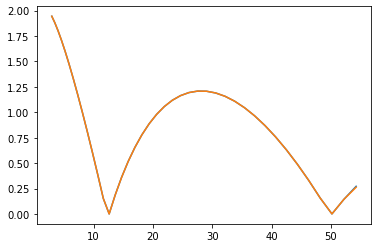

In [23]:
prediction_y = np.concatenate([X[:, 1:2], y_pred]).reshape(-1)
truth = np.concatenate([X, y_hat])
truth_x = truth[:, 0]
truth_y = truth[:, 1]

plt.plot(truth_x, truth_y)
plt.plot(truth_x, prediction_y)

### Multi-Prediction

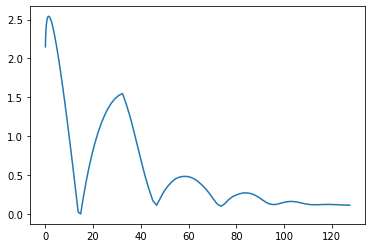

In [26]:
X = X_test[60]
for i in range(60):
    y_pred = model.predict(X[-SERIES_LENGTH:, :].reshape(1, SERIES_LENGTH, 2))
    x = X[-1, 0]*2 - X[-2, 0]
    col = np.array([x, y_pred]).reshape(1, 2)
    X = np.concatenate([X, col])
    
plt.plot(X[:, 0], X[:, 1])